# 파이토치 패키지 중급

## GPU 사용

이전 데이터 타입에서 보았듯이 GPU 연산을 하기위해선 텐서를 GPU 연산이 가능한 자료형으로 변환하면 된다. 이에 앞서 본인의 환경에 GPU가 있어야 한다. 사용하는 환경이 GPU를 사용할 수 있는지 확인 하려면 `torch.cuda.is_available()`을 실행 시켜 보면 된다. 만약 GPU를 사용할 준비가 되었다면, `True`를 반환 할 것이다. 

In [29]:
import torch
import torch
import numpy as np 
import pandas as pd 
torch.__version__

'1.1.0'

In [30]:
torch.cuda.is_available()

True

GPU 연산이 가능한 Tensor를 만드는 것은 device 인수에 GPU 디바이스 객체를 입력하거나 문자열을 입력하면 된다. 디바이스 객체는 `torch.device("cuda:0")`로 생성할 수 있다. 

In [31]:
device = torch.device("cuda:0")
device

device(type='cuda', index=0)

In [32]:
ts = torch.rand(3,3,device=device)
ts

tensor([[0.0297, 0.7846, 0.0723],
        [0.4618, 0.5478, 0.1851],
        [0.3033, 0.6481, 0.4553]], device='cuda:0')

In [33]:
ts = torch.rand(3,3,device="cuda:0")
ts

tensor([[0.2048, 0.9162, 0.4881],
        [0.5533, 0.3083, 0.6625],
        [0.5697, 0.3028, 0.5965]], device='cuda:0')

기존에 있는 Tensor를 GPU 연산이 가능한 자료형으로 바꿀 때는= `.cuda()` 메서드를 사용한다. 

In [34]:
cp = torch.rand(3, 3)
cp

tensor([[0.4482, 0.5442, 0.1801],
        [0.4044, 0.6603, 0.1557],
        [0.3710, 0.8915, 0.1705]])

In [35]:
cp.cuda()

tensor([[0.4482, 0.5442, 0.1801],
        [0.4044, 0.6603, 0.1557],
        [0.3710, 0.8915, 0.1705]], device='cuda:0')

## autograd 

autograd는 PyTorch에서 핵심적인 기능을 담당하는 하부 패키지이다. autograd는 텐서의 연산에 대해 자동으로 미분값을 구해주는 기능을 한다.
텐서 자료를 생성할 때, `requires_grad`인수를 `True`로 설정하거나 `.requires_grad_(True)`를 실행하면 그 텐서에 행해지는 모든 연산에 대한 미분값을 계산한다. 계산을 멈추고 싶으면 `.detach()`함수를 이용하면 된다.. 예제를 통해 알아 보도록 하자. `requires_grad`인수를 `True`로 설정하여  Tensor를 생성했다. 

In [36]:
x = torch.rand(2, 2, requires_grad=True)
print(x)

tensor([[0.7254, 0.0362],
        [0.5378, 0.0865]], requires_grad=True)


다음으로 이 x에 연산을 수행한다. 다음 코드의 y는 연산의 결과이므로 미분 함수를 가진다. `grad_fn`속성을 출력해 미분 함수를 확인 할 수 있다. 

In [37]:
y = torch.sum(x * 3)
print(y, y.grad_fn)

tensor(4.1577, grad_fn=<SumBackward0>) <SumBackward0 object at 0x7f8490a05cf8>


`y.backward()` 함수를 실행하면 x의 미분값이 자동으로 갱신된다. x의 `grad`속성을 확인하면 미분값이 들어 있는 것을 확인 할 수 있다. y를 구하기 위한 x의 연산을 수식으로 쓰면 다음과 같다. 

$$
y = \displaystyle\sum_{i=1}^4 3 \times x_i
$$

이를 $x_i$에 대해 미분 하면 미분 함수는 다음과 같다. 

$$
\dfrac{\partial y}{\partial x_i} = 3
$$

실제 미분값과 같은지 확인해보자.

In [38]:
print(x.grad)

None


In [0]:
y.backward(retain_graph=True)

In [40]:
x.grad

tensor([[3., 3.],
        [3., 3.]])

`backward()`함수는 자동으로 미분값을 계산해 `requires_grad`인수가 True로 설정된 변수의 `grad`속성의 값을 갱신한다. `retain_graph` 미분을 연산하기 위해서 사용했던 임시 그래프를 유지 할 것인가를 설정하는 것이다. 기본값은 False로 설정되어 있지만 동일한 연산에 대해 여러번 미분을 계산하기 위해서는 True로 설정되어 있어야한다. 그리고 미분값을 그대로 출력받아 사용하고 싶은 경우에는 `torch.autograd.grad()`함수에 출력값과 입력값을 입력하면 미분값을 출력한다. 

In [41]:
torch.autograd.grad(y, x)

(tensor([[3., 3.],
         [3., 3.]]),)

상황에 따라 특정 연산에는 미분값을 계산하고 싶지 않은 경우에는 `.detach()`함수를 사용한다. 예를 들어, 이전 코드의 결과 값 `y`에 로지스틱 함수 연산을 수행하고 이에 대한 미분 값을 계산 하고 싶지 않은 경우에 다음처럼 할 수 있다. 

In [42]:
y_1 = y.detach()
torch.sigmoid(y_1)

tensor(0.9846)

## PyTorch를 이용한 선형 회귀 구현

지금까지 배운 내용으로 선형회귀를 구현한다.

In [43]:
from sklearn.datasets import load_boston

boston = load_boston()
df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['const'] = np.ones(df.shape[0])
df.tail()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,const
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,1.0
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,1.0
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,1.0
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,1.0
505,0.04741,0.0,11.93,0.0,0.573,6.030,80.8,2.5050,1.0,273.0,21.0,396.90,7.88,1.0


In [44]:
n, m = df.shape

X = torch.tensor(df.values)
y = torch.tensor(boston.target).view(-1, 1)

XT = torch.transpose(X, 0, 1)
w = torch.matmul(torch.matmul(torch.inverse(torch.matmul(XT, X)), XT), y)
y_pred = torch.matmul(X, w)


print("예측한 집값 :", y_pred[19], "실제 집값 :", boston.target[19])

예측한 집값 : tensor([18.4061], dtype=torch.float64) 실제 집값 : 18.2


## PyTorch를 이용한 퍼셉트론 구현 

이번에는 붓꽃 분류 문제를 해결하는 퍼셉트론 모형을 구현한다. 

In [0]:
from sklearn.datasets import load_iris

iris = load_iris()

idx = np.in1d(iris.target, [0, 2])
x = torch.from_numpy(iris.data[idx, 0:2]).type(torch.float64)
y = torch.from_numpy((iris.target[idx] - 1.0)
                     [:, np.newaxis]).type(torch.float64)

모형에 사용하는 변수를 `requires_grad`인수를 True로 하여 생성한다.

In [0]:
w = torch.rand((2, 1), dtype=torch.float64, requires_grad=True)
b = torch.rand((1, 1), dtype=torch.float64, requires_grad=True)

생성한 변수에 직접 연산을 수행해서는 안된다. 방금 예 처럼 "w" 라는 변수명으로 변수를 할당하고 이 변수를 연산 할 때 파이썬에서 하듯이 

    w = 0.001 * w
    
이렇게 해서는 안된다. 변수에 연산의 결과 값이 들어가면서 이 후 해당 변수는 이전에 생성한 변수가 아니고, 따라서 더이상 `requires_grad`가 True로 설정되어 있지 않다. 변수에 연산, 할당을 하고 싶을 때는 변수의 `data`속성을 불러와 변경하면 된다. 

In [0]:
w.data *= 0.001
b.data *= 0.001

다음으로 SGD 최적화를 수행한다. `.backward()`를 사용하면 미분값이 계속 누적된다. 우리는 학습한 뒤 가중치를 수정하고 수정한 가중치에 대한 미분값으로 다시 학습하는 것이기 때문에 가중치를 수정한 뒤에 `.grad_zero_()`함수를 호출하여 변수에 할당된 미분값을 0으로 만들어준다. 

In [48]:
learning_rate = 1e-6
epochs = 100

for epoch in range(epochs):
    z = (x.mm(w) + b).tanh()
    loss_vec = torch.mul(-y, z)
    loss = torch.sum(torch.max(
        torch.cat([torch.zeros_like(loss_vec), loss_vec], dim=-1), dim=-1)[0], dim=-1)
    loss.backward()
    w.data -= w.grad * learning_rate
    b.data -= b.grad * learning_rate
    if epoch % 10 == 0:
        print("{:3} - loss : {:3.2}".format(epoch, loss.item()))
    w.grad.zero_()
    b.grad.zero_()

  0 - loss : 0.27
 10 - loss : 0.052
 20 - loss : 0.036
 30 - loss : 0.014
 40 - loss : 0.019
 50 - loss : 0.00021
 60 - loss : 0.00019
 70 - loss : 0.0002
 80 - loss : 0.0002
 90 - loss : 0.00019


In [49]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y, [-1 if p < 0 else 1 for p in z.detach().numpy()])

array([[49,  1],
       [ 1, 49]])

## PyTorch를 이용한 신경망 구현 

PyTorch 다양한 신경망 모형을 쉽게 구현 할 수 있도록 `torch.nn.module`을 제공한다. 이를 이용해 간단한 신경망 모형을 구현한다. PyTorch에서는 샘플데이터를 제공하지 않으므로 샘플데이터는 Keras를 이용해 MNIST 숫자 데이터를 불러오겠다.

In [0]:
from keras.datasets import fashion_mnist, mnist

import torch

(X_train0, y_train), (X_test0, y_test) = mnist.load_data()

In [51]:
print(X_train0.shape, X_train0.dtype)
print(y_train.shape, y_train.dtype)
print(X_test0.shape, X_test0.dtype)
print(y_test.shape, y_test.dtype)

(60000, 28, 28) uint8
(60000,) uint8
(10000, 28, 28) uint8
(10000,) uint8


이전에 Keras에서 했던 방식과 같이 전처리를 진행한다. 다만 여기서는 정답데이터에 대한 원핫인코딩작업을 하지 않는다. 이유는 바로 다음에 설명할 것이다. 전처리를 수행했으면 PyTorch가 사용할 수 있는 텐서로 변환하고 각각 알맞는 데이터 타입으로 변환한다. 이미지데이터에 대해서는 float 타입, 출력데이터에 대해서는 int64 타입으로 변환한다. 이는 추후 사용할 PyTorch의 함수가 해당 데이터 타입을 지원하기 때문이다.

In [0]:
X_train = X_train0.reshape(60000, 784).astype('float64') / 255.0
X_test = X_test0.reshape(10000, 784).astype('float64') / 255.0

X_train, y_train, X_test, y_test = map(
    torch.tensor, (X_train, y_train, X_test, y_test))

X_train, y_train, X_test, y_test = X_train.float(
), y_train.long(), X_test.float(), y_test.long()

`torch.nn.Sequential`을 이용하면 손쉽게 모델을 구성할 수 있다. 이전 Keras의 방식과 유사하다. 다만 명령어가 조금씩 다를 뿐이다. 이전에 Keras로 구현한 것과 동일한 구조로 구성한다. `torch.nn.Linear`는 레이어 간의 선형결합을 의미하고 이를 활성화함수에 통과시키면 이전에 배웠던 MLP(multi layer perceptron)구조가 된다. 28x28크기의 이미지를 1차원 벡터로 만들어 입력하고 15개 노드의 은닉층을 거쳐 10개 노드를 출력한다. 이 모형을 GPU를 사용해 학습시키고 싶다면 모형과 사용할 데이터를 GPU연산 가능 자료형으로 변환하면 된다.

In [0]:
from torch import nn

model = nn.Sequential(
    nn.Linear(784, 15),
    nn.Sigmoid(),
    nn.Linear(15, 10),
    nn.Sigmoid(),
).cuda()

PyTorch에서 최적화 알고리즘은 `torch.optim`에 정의되어 있다. 다음처럼 `torch.optim`클래스에서 원하는 최적화 방법을 정의한다. 여기서는 SGD방법을 사용한다. 그리고 대부분의 비용함수는 `torch.nn`클래스에 구현되어 있다. 여기서는 크로스 엔트로피 비용함수(Cross Entropy Loss)를 사용한다. 크로스 엔트로피 비용함수는 신경망 모형을 이용해 분류문제를 풀 때 많이 사용하는 비용함수이다. 이는 추후 신경망 성능개선 다룰 것이다. 

In [0]:
from torch import optim

opt = optim.SGD(model.parameters(), lr=0.5)
loss_fn = torch.nn.CrossEntropyLoss()

In [55]:
def accuracy(pred, y):
    preds = torch.argmax(pred, dim=1)
    return (preds == y).float().mean()


epochs = 10
n = X_train.shape[0]
bs = 100

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = X_train[start_i:end_i].cuda()
        yb = y_train[start_i:end_i].cuda()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    acc = accuracy(pred, yb)
    print("{:2} epoch - cross entropy : {:4.2}, accuracy : {:4.2}".format(
        epoch + 1, loss.detach().item(), acc.detach().item()))

 1 epoch - cross entropy :  1.8, accuracy : 0.84
 2 epoch - cross entropy :  1.7, accuracy : 0.88
 3 epoch - cross entropy :  1.6, accuracy : 0.88
 4 epoch - cross entropy :  1.6, accuracy : 0.87
 5 epoch - cross entropy :  1.6, accuracy : 0.87
 6 epoch - cross entropy :  1.6, accuracy : 0.86
 7 epoch - cross entropy :  1.6, accuracy : 0.87
 8 epoch - cross entropy :  1.6, accuracy : 0.88
 9 epoch - cross entropy :  1.6, accuracy : 0.89
10 epoch - cross entropy :  1.6, accuracy : 0.91


`hiddenlayer` 패키지를 사용하면 PyTorch로 구현한 모델의 그래프를 시각화 할 수 있다. 설치하는 방법은 다음과 같다. 

In [56]:
!pip install hiddenlayer

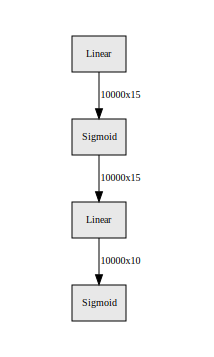

In [57]:
import hiddenlayer as hl

hl.build_graph(model=model, args=torch.zeros([10000, 784]).cuda())